<a href="https://colab.research.google.com/github/Mounika559/Crime-Rate-Project/blob/main/Facial_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Step-1: Install Required Dependencies***

---








In [225]:
!pip install deepface
!pip install opencv-python
!pip install yt-dlp
!pip install librosa
!pip install matplotlib
!pip install pandas
!pip install ffmpeg-python

***Step-2: Import Require Libraries and Do Setup***

---



In [226]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deepface import DeepFace
import librosa
import subprocess
from collections import Counter
import json
import time
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully!")

 All libraries imported successfully!


***Step-3: Download Facial Emotion Recognition Video***

---



In [227]:
def download_video():
    print(" Downloading video from YouTube")

    video_url = "https://www.youtube.com/watch?v=v66sOeZJDEk"
    output_filename = "facial_video.%(ext)s"

    command = [
        'yt-dlp',
        '-f', 'mp4',
        '-o', output_filename,
        '--no-playlist',
        video_url
    ]

    try:
        result = subprocess.run(command, check=True, capture_output=True, text=True)
        video_path = "facial_video.mp4"

        if os.path.exists(video_path):
            print(f" Video downloaded successfully: {video_path}")
            return video_path
        else:
            print(" Video file not found after download")
            return None
    except subprocess.CalledProcessError as e:
        print(f" Error downloading video: {e}")
        print(f"Error output: {e.stderr}")
        return None

In [228]:
# Download the video
video_path = download_video()
print(f"Video path: {video_path}")

 Video downloaded successfully: facial_video.mp4
Video path: facial_video.mp4


***Step-4: Audio Extract***

---



In [229]:
def extract_audio(video_path, output_path="facial_audio.wav"):
    """Extract audio from video as mono WAV at 16kHz"""
    if not video_path or not os.path.exists(video_path):
        print(" Video file not found")
        return None

    print(" Extracting audio from video...")

    command = [
        'ffmpeg', '-i', video_path,
        '-ac', '1',          # mono
        '-ar', '16000',      # 16kHz sample rate
        '-acodec', 'pcm_s16le',  # PCM 16-bit
        '-y',                # overwrite output file
        output_path
    ]

    try:
        subprocess.run(command, check=True, capture_output=True, text=True)
        print(f" Audio extracted successfully: {output_path}")
        return output_path
    except subprocess.CalledProcessError as e:
        print(f" Error extracting audio: {e}")
        return None##

In [230]:
# Extract audio
audio_path = extract_audio(video_path)

 Extracting audio from video...
 Audio extracted successfully: facial_audio.wav


***Step-5: Extract Frame***

---



In [231]:
def extract_frames(video_path):
    """Extract one frame per second from video"""
    if not video_path or not os.path.exists(video_path):
        print(" Video file not found")
        return [], []

    print(" Extracting frames from video...")

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    print(f" Video Info: {fps:.2f} FPS, {total_frames} total frames, {duration:.2f}s duration")

    frames = []
    timestamps = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Extract frame every second
        if frame_count % int(fps) == 0:
            timestamp = frame_count / fps
            frames.append(frame.copy())
            timestamps.append(timestamp)
            print(f" Extracted frame at {timestamp:.1f}s")

        frame_count += 1

    cap.release()
    print(f" Extracted {len(frames)} frames total")
    return frames, timestamps

# Extract frames
frames, timestamps = extract_frames(video_path)

 Extracting frames from video...
 Video Info: 23.98 FPS, 473 total frames, 19.73s duration
 Extracted frame at 0.0s
 Extracted frame at 1.0s
 Extracted frame at 1.9s
 Extracted frame at 2.9s
 Extracted frame at 3.8s
 Extracted frame at 4.8s
 Extracted frame at 5.8s
 Extracted frame at 6.7s
 Extracted frame at 7.7s
 Extracted frame at 8.6s
 Extracted frame at 9.6s
 Extracted frame at 10.6s
 Extracted frame at 11.5s
 Extracted frame at 12.5s
 Extracted frame at 13.4s
 Extracted frame at 14.4s
 Extracted frame at 15.3s
 Extracted frame at 16.3s
 Extracted frame at 17.3s
 Extracted frame at 18.2s
 Extracted frame at 19.2s
 Extracted 21 frames total


***Step-6: Visualizing Extracted Frames***

---



 Displaying extracted frames...


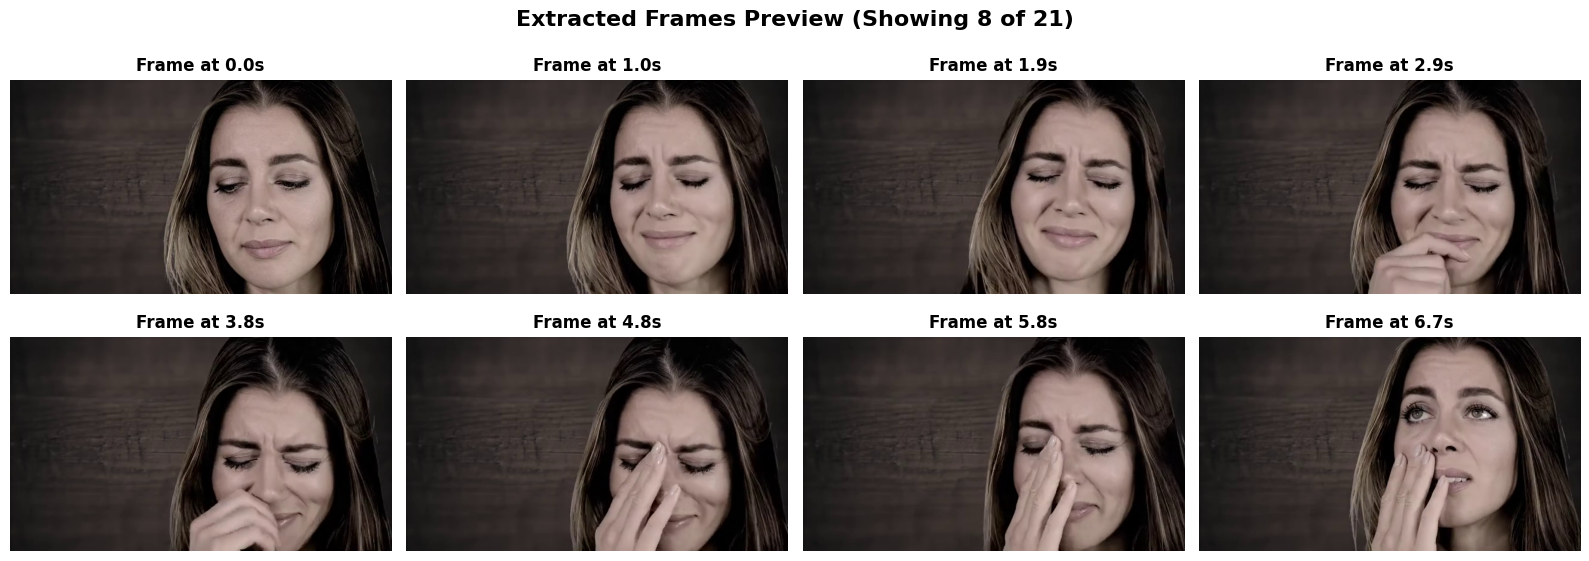

In [232]:
def visualize_extracted_frames(frames, timestamps, max_display=8):
    """Visualize the extracted frames"""
    if not frames:
        print("No frames to display")
        return

    print(f" Displaying extracted frames...")

    display_count = min(len(frames), max_display)
    cols = 4
    rows = (display_count + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))

    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i in range(display_count):
        # Convert BGR to RGB for display
        frame_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f'Frame at {timestamps[i]:.1f}s', fontweight='bold')
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(display_count, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'Extracted Frames Preview (Showing {display_count} of {len(frames)})',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize frames
visualize_extracted_frames(frames, timestamps)

***Step-7: Emotion Detection***

---



In [233]:
def analyze_emotions(frames, timestamps):
    """Analyze emotions in each frame using DeepFace"""
    print(" Starting emotion analysis...")

    emotion_results = []

    for i, (frame, timestamp) in enumerate(zip(frames, timestamps)):
        print(f" Analyzing frame {i+1}/{len(frames)} at {timestamp:.1f}s...")

        start_time = time.time()

        try:
            # Analyze emotion using DeepFace
            result = DeepFace.analyze(
                frame,
                actions=['emotion'],
                enforce_detection=False,
                silent=True
            )

            # Handle both single result and list of results
            if isinstance(result, list):
                result = result[0]

            dominant_emotion = result['dominant_emotion']
            confidence = result['emotion'][dominant_emotion]
            all_emotions = result['emotion']

            processing_time = time.time() - start_time

            emotion_data = {
                'timestamp': timestamp,
                'dominant_emotion': dominant_emotion,
                'confidence': confidence,
                'all_emotions': all_emotions,
                'processing_time': processing_time,
                'face_detected': True
            }

            print(f" {timestamp:.1f}s: {dominant_emotion} ({confidence:.1f}%)")

        except Exception as e:
            print(f" Error analyzing frame at {timestamp:.1f}s: {str(e)}")

            processing_time = time.time() - start_time
            emotion_data = {
                'timestamp': timestamp,
                'dominant_emotion': 'unknown',
                'confidence': 0.0,
                'all_emotions': {},
                'processing_time': processing_time,
                'face_detected': False
            }

        emotion_results.append(emotion_data)

    print(f" Emotion analysis complete! Processed {len(emotion_results)} frames")
    return emotion_results

# Run emotion analysis
emotion_results = analyze_emotions(frames, timestamps)

 Starting emotion analysis...
 Analyzing frame 1/21 at 0.0s...
 0.0s: happy (46.6%)
 Analyzing frame 2/21 at 1.0s...
 1.0s: disgust (75.4%)
 Analyzing frame 3/21 at 1.9s...
 1.9s: disgust (98.3%)
 Analyzing frame 4/21 at 2.9s...
 2.9s: disgust (43.1%)
 Analyzing frame 5/21 at 3.8s...
 3.8s: disgust (96.8%)
 Analyzing frame 6/21 at 4.8s...
 4.8s: sad (100.0%)
 Analyzing frame 7/21 at 5.8s...
 5.8s: sad (100.0%)
 Analyzing frame 8/21 at 6.7s...
 6.7s: fear (99.3%)
 Analyzing frame 9/21 at 7.7s...
 7.7s: fear (99.4%)
 Analyzing frame 10/21 at 8.6s...
 8.6s: fear (99.9%)
 Analyzing frame 11/21 at 9.6s...
 9.6s: fear (99.9%)
 Analyzing frame 12/21 at 10.6s...
 10.6s: fear (61.0%)
 Analyzing frame 13/21 at 11.5s...
 11.5s: fear (77.1%)
 Analyzing frame 14/21 at 12.5s...
 12.5s: happy (99.5%)
 Analyzing frame 15/21 at 13.4s...
 13.4s: happy (99.4%)
 Analyzing frame 16/21 at 14.4s...
 14.4s: happy (99.3%)
 Analyzing frame 17/21 at 15.3s...
 15.3s: happy (98.9%)
 Analyzing frame 18/21 at 16.3s.

***Step-8: Visualize Extracted Frames with Detected Emotions***

---




In [234]:
def visualize_extracted_frames_with_emotions(frames, timestamps, emotion_results, max_display=None):
    """Visualize all extracted frames with their detected emotions"""
    if not frames:
        print(" No frames to display")
        return

    if not emotion_results:
        print(" No emotion results available")
        return

    print(f" Displaying all extracted frames with detected emotions...")

    # Display all frames if max_display is None, otherwise limit
    display_count = len(frames) if max_display is None else min(len(frames), max_display)

    # Dynamic grid calculation for better layout
    if display_count <= 4:
        cols = display_count
        rows = 1
    elif display_count <= 12:
        cols = 4
        rows = (display_count + cols - 1) // cols
    else:
        # For larger numbers, use more columns
        cols = 6
        rows = (display_count + cols - 1) // cols

    # Adjust figure size based on number of frames
    fig_width = max(18, cols * 3)
    fig_height = max(10, rows * 3)

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

    # Handle different subplot configurations
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    # Color mapping for emotions
    emotion_colors = {
        'happy': '#FFD700',      # Gold
        'sad': '#4169E1',        # Royal Blue
        'angry': '#DC143C',      # Crimson
        'fear': '#8A2BE2',       # Blue Violet
        'surprise': '#FF8C00',   # Dark Orange
        'disgust': '#32CD32',    # Lime Green
        'neutral': '#808080',    # Gray
        'unknown': '#000000'     # Black
    }

    for i in range(display_count):
        # Convert BGR to RGB for display
        frame_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        axes_flat[i].imshow(frame_rgb)

        # Get emotion data for this frame
        if i < len(emotion_results):
            emotion_data = emotion_results[i]
            emotion = emotion_data['dominant_emotion']
            confidence = emotion_data['confidence']
            face_detected = emotion_data['face_detected']

            # Create title with emotion info
            if face_detected:
                title = f'Frame {i+1} at {timestamps[i]:.1f}s\n{emotion.upper()}\nConfidence: {confidence:.1f}%'
                title_color = emotion_colors.get(emotion, '#000000')
            else:
                title = f'Frame {i+1} at {timestamps[i]:.1f}s\nNO FACE DETECTED'
                title_color = '#FF0000'  # Red for no detection
        else:
            title = f'Frame {i+1} at {timestamps[i]:.1f}s\nNO ANALYSIS'
            title_color = '#000000'

        axes_flat[i].set_title(title, fontweight='bold', fontsize=9, color=title_color)
        axes_flat[i].axis('off')

        # Add colored border based on emotion
        if i < len(emotion_results) and emotion_results[i]['face_detected']:
            emotion = emotion_results[i]['dominant_emotion']
            border_color = emotion_colors.get(emotion, '#000000')
            for spine in axes_flat[i].spines.values():
                spine.set_visible(True)
                spine.set_color(border_color)
                spine.set_linewidth(3)

    # Hide unused subplots
    for i in range(display_count, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.suptitle(f'Extracted Frames with Emotion Detection (Showing all {display_count} frames)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary of detected emotions
    print("\n EMOTION DETECTION SUMMARY:")
    print("=" * 50)
    detected_emotions = {}
    no_face_count = 0

    for i, result in enumerate(emotion_results[:display_count]):
        if result['face_detected']:
            emotion = result['dominant_emotion']
            detected_emotions[emotion] = detected_emotions.get(emotion, 0) + 1
            print(f"Frame {i+1:2d}: {emotion.upper():<10} (Confidence: {result['confidence']:5.1f}%)")
        else:
            no_face_count += 1
            print(f"Frame {i+1:2d}: NO FACE DETECTED")

    print("\n EMOTION DISTRIBUTION:")
    print("-" * 30)
    for emotion, count in sorted(detected_emotions.items()):
        percentage = (count / display_count) * 100
        print(f"{emotion.capitalize():<10}: {count:2d} frames ({percentage:5.1f}%)")

    if no_face_count > 0:
        percentage = (no_face_count / display_count) * 100
        print(f"No Face    : {no_face_count:2d} frames ({percentage:5.1f}%)")


In [235]:
# Create emotion color
def show_emotion_color_set():
    """Display color legend for emotions"""
    emotion_colors = {
        'Happy': '#FFD700',
        'Sad': '#4169E1',
        'Angry': '#DC143C',
        'Fear': '#8A2BE2',
        'Surprise': '#FF8C00',
        'Disgust': '#32CD32',
        'Neutral': '#808080',
        'No Face': '#FF0000'
    }

    fig, ax = plt.subplots(figsize=(10, 2))
    y_pos = 0.5

    for i, (emotion, color) in enumerate(emotion_colors.items()):
        x_pos = i / len(emotion_colors)
        ax.add_patch(plt.Rectangle((x_pos, 0.3), 0.12, 0.4, facecolor=color, alpha=0.8))
        ax.text(x_pos + 0.06, 0.1, emotion, ha='center', va='center', fontweight='bold', fontsize=10)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title('Emotion Color Setting', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

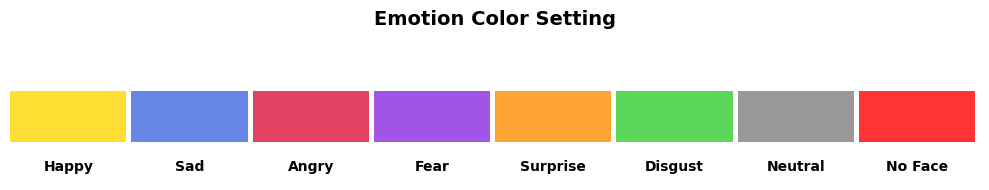

In [236]:
show_emotion_color_set()

 Displaying all extracted frames with detected emotions...


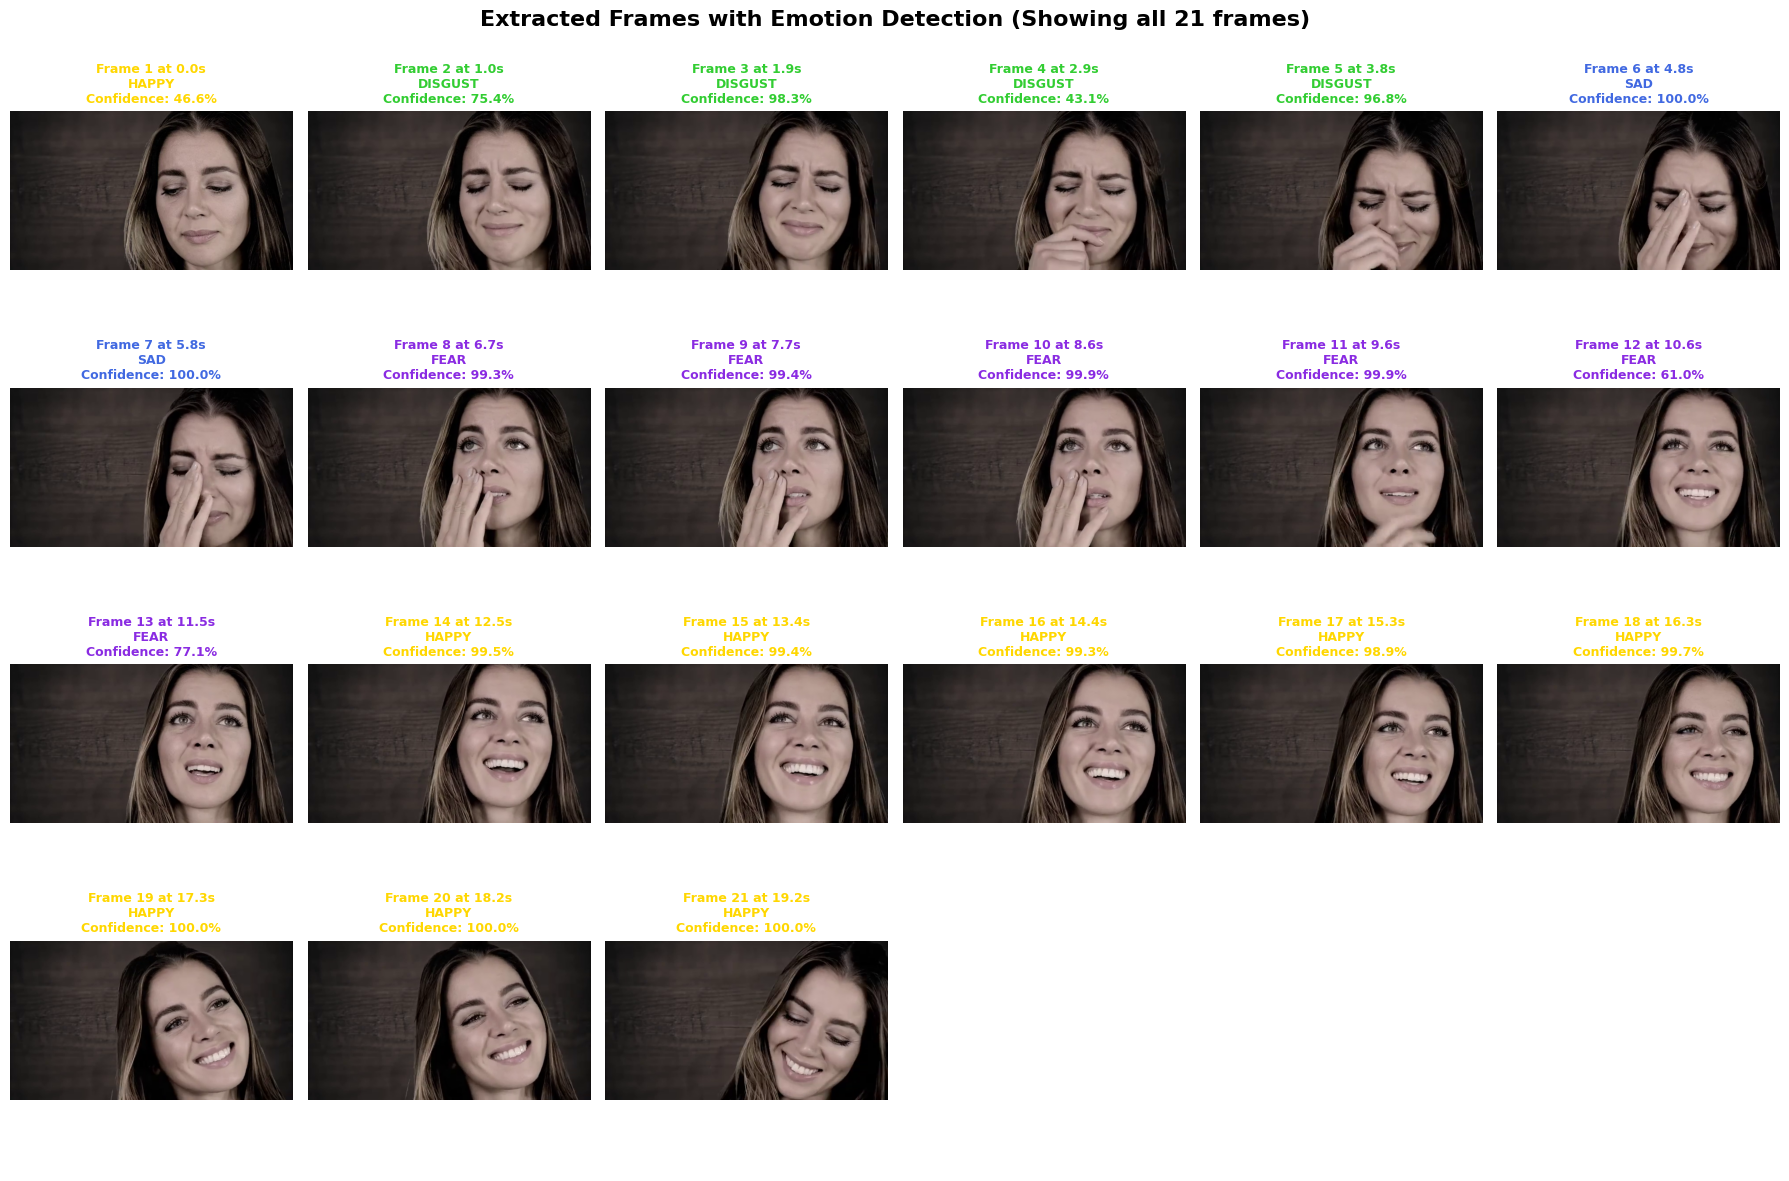


 EMOTION DETECTION SUMMARY:
Frame  1: HAPPY      (Confidence:  46.6%)
Frame  2: DISGUST    (Confidence:  75.4%)
Frame  3: DISGUST    (Confidence:  98.3%)
Frame  4: DISGUST    (Confidence:  43.1%)
Frame  5: DISGUST    (Confidence:  96.8%)
Frame  6: SAD        (Confidence: 100.0%)
Frame  7: SAD        (Confidence: 100.0%)
Frame  8: FEAR       (Confidence:  99.3%)
Frame  9: FEAR       (Confidence:  99.4%)
Frame 10: FEAR       (Confidence:  99.9%)
Frame 11: FEAR       (Confidence:  99.9%)
Frame 12: FEAR       (Confidence:  61.0%)
Frame 13: FEAR       (Confidence:  77.1%)
Frame 14: HAPPY      (Confidence:  99.5%)
Frame 15: HAPPY      (Confidence:  99.4%)
Frame 16: HAPPY      (Confidence:  99.3%)
Frame 17: HAPPY      (Confidence:  98.9%)
Frame 18: HAPPY      (Confidence:  99.7%)
Frame 19: HAPPY      (Confidence: 100.0%)
Frame 20: HAPPY      (Confidence: 100.0%)
Frame 21: HAPPY      (Confidence: 100.0%)

 EMOTION DISTRIBUTION:
------------------------------
Disgust   :  4 frames ( 19.0%)
Fea

In [237]:
visualize_extracted_frames_with_emotions(frames, timestamps, emotion_results)

***Step-9: Generating Summary and Insights***

---



In [238]:
def generate_summary(emotion_results):
    """Generate comprehensive summary of emotion analysis"""
    print(" Generating emotion analysis summary...")

    # Filter valid detections
    valid_results = [r for r in emotion_results if r['face_detected']]
    total_frames = len(emotion_results)
    faces_detected = len(valid_results)

    if not valid_results:
        return {
            'total_frames': total_frames,
            'faces_detected': 0,
            'detection_rate': 0,
            'most_common_emotion': 'none',
            'summary_text': "No faces detected in any frames."
        }

    # Extract emotions and confidences
    emotions = [r['dominant_emotion'] for r in valid_results]
    confidences = [r['confidence'] for r in valid_results]
    timestamps_valid = [r['timestamp'] for r in valid_results]

    # Calculate statistics
    emotion_counts = Counter(emotions)
    most_common_emotion = emotion_counts.most_common(1)[0][0]
    most_common_count = emotion_counts.most_common(1)[0][1]

    avg_confidence = np.mean(confidences)
    detection_rate = (faces_detected / total_frames) * 100

    # Detect emotional shifts
    emotional_shifts = []
    last_emotion = None

    for r in valid_results:
        current_emotion = r['dominant_emotion']
        if last_emotion and current_emotion != last_emotion:
            shift_text = f"{last_emotion} → {current_emotion} at {r['timestamp']:.1f}s"
            emotional_shifts.append(shift_text)
        last_emotion = current_emotion

    # Generate summary text
    summary_text = f"""
EMOTION ANALYSIS SUMMARY:
========================
• Most common emotion: {most_common_emotion.upper()} ({most_common_count} times)
• Face detection rate: {detection_rate:.1f}% ({faces_detected}/{total_frames} frames)
• Average confidence: {avg_confidence:.1f}%
• Total emotional shifts: {len(emotional_shifts)}
"""

    if emotional_shifts:
        summary_text += f"\nKey emotional transitions:\n"
        for shift in emotional_shifts[:3]:  # Show first 3 shifts
            summary_text += f"  • {shift}\n"
    else:
        summary_text += "\n• No significant emotional shifts detected\n"

    # Create detailed summary dictionary
    summary = {
        'total_frames': total_frames,
        'faces_detected': faces_detected,
        'detection_rate': detection_rate,
        'most_common_emotion': most_common_emotion,
        'most_common_count': most_common_count,
        'average_confidence': avg_confidence,
        'emotion_distribution': dict(emotion_counts),
        'emotional_shifts': emotional_shifts,
        'summary_text': summary_text,
        'valid_results': valid_results
    }

    return summary

In [239]:
# Generate summary
summary = generate_summary(emotion_results)
print(summary['summary_text'])

 Generating emotion analysis summary...

EMOTION ANALYSIS SUMMARY:
• Most common emotion: HAPPY (9 times)
• Face detection rate: 100.0% (21/21 frames)
• Average confidence: 90.2%
• Total emotional shifts: 4

Key emotional transitions:
  • happy → disgust at 1.0s
  • disgust → sad at 4.8s
  • sad → fear at 6.7s



***Step-10: Create Comprehensive Visualizations***

---



In [240]:
def create_emotion_visualizations(emotion_results, summary):
    """Create comprehensive emotion analysis visualizations"""
    valid_results = summary['valid_results']

    if not valid_results:
        print(" No valid emotion detections to visualize")
        return

    print(" Creating emotion analysis visualizations...")

    # Extract data for plotting
    timestamps_valid = [r['timestamp'] for r in valid_results]
    emotions_valid = [r['dominant_emotion'] for r in valid_results]
    confidences_valid = [r['confidence'] for r in valid_results]

    # Color mapping
    emotion_colors = {
        'happy': '#FFD700', 'sad': '#4169E1', 'angry': '#DC143C',
        'fear': '#8A2BE2', 'surprise': '#FF8C00', 'disgust': '#32CD32',
        'neutral': '#808080'
    }

    # Create comprehensive figure
    fig = plt.figure(figsize=(20, 12))

    # 1. Emotion Timeline
    plt.subplot(2, 3, 1)
    colors = [emotion_colors.get(e, '#000000') for e in emotions_valid]
    scatter = plt.scatter(timestamps_valid, emotions_valid,
                         c=colors, s=[c*2 for c in confidences_valid],
                         alpha=0.8, edgecolors='black', linewidth=1)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Dominant Emotion')
    plt.title('Emotion Timeline\n(Size = Confidence Level)', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Add emotion shift markers
    for i in range(1, len(valid_results)):
        if emotions_valid[i-1] != emotions_valid[i]:
            plt.axvline(x=timestamps_valid[i], color='red', linestyle='--', alpha=0.7)

    # 2. Confidence Over Time
    plt.subplot(2, 3, 2)
    plt.plot(timestamps_valid, confidences_valid, 'o-', color='navy', linewidth=2, markersize=6)
    plt.fill_between(timestamps_valid, confidences_valid, alpha=0.3, color='lightblue')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Confidence (%)')
    plt.title('Detection Confidence Over Time', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% Threshold')
    plt.legend()

    # 3. Emotion Distribution
    plt.subplot(2, 3, 3)
    emotion_counts = summary['emotion_distribution']
    colors_pie = [emotion_colors.get(emotion, '#000000') for emotion in emotion_counts.keys()]
    wedges, texts, autotexts = plt.pie(emotion_counts.values(),
                                      labels=emotion_counts.keys(),
                                      colors=colors_pie,
                                      autopct='%1.1f%%',
                                      startangle=90)
    plt.title('Emotion Distribution', fontweight='bold')

    # 4. Emotion Intensity Heatmap
    plt.subplot(2, 3, 4)
    all_emotions = ['happy', 'sad', 'angry', 'fear', 'surprise', 'disgust', 'neutral']
    emotion_matrix = []

    for result in valid_results:
        row = [result['all_emotions'].get(emotion, 0) for emotion in all_emotions]
        emotion_matrix.append(row)

    if emotion_matrix:
        emotion_matrix = np.array(emotion_matrix).T
        im = plt.imshow(emotion_matrix, cmap='YlOrRd', aspect='auto', interpolation='nearest')
        plt.colorbar(im, label='Confidence %')
        plt.yticks(range(len(all_emotions)), all_emotions)
        plt.xlabel('Time Frames')
        plt.ylabel('Emotions')
        plt.title('Emotion Intensity Heatmap', fontweight='bold')

    # 5. Processing Statistics
    plt.subplot(2, 3, 5)
    processing_times = [r['processing_time'] for r in emotion_results]
    colors_proc = ['green' if r['face_detected'] else 'red' for r in emotion_results]
    plt.bar(range(len(processing_times)), processing_times, color=colors_proc, alpha=0.7)
    plt.xlabel('Frame Number')
    plt.ylabel('Processing Time (seconds)')
    plt.title('Processing Time per Frame', fontweight='bold')
    avg_time = np.mean(processing_times)
    plt.axhline(y=avg_time, color='black', linestyle='--',
               label=f'Average: {avg_time:.2f}s')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Summary Statistics
    plt.subplot(2, 3, 6)
    plt.axis('off')
    stats_text = f"""
ANALYSIS STATISTICS

Total Frames: {summary['total_frames']}
Faces Detected: {summary['faces_detected']}
Detection Rate: {summary['detection_rate']:.1f}%

Most Common Emotion:
{summary['most_common_emotion'].upper()}
({summary['most_common_count']} occurrences)

Average Confidence:
{summary['average_confidence']:.1f}%

Emotional Shifts:
{len(summary['emotional_shifts'])} detected
"""
    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

 Creating emotion analysis visualizations...


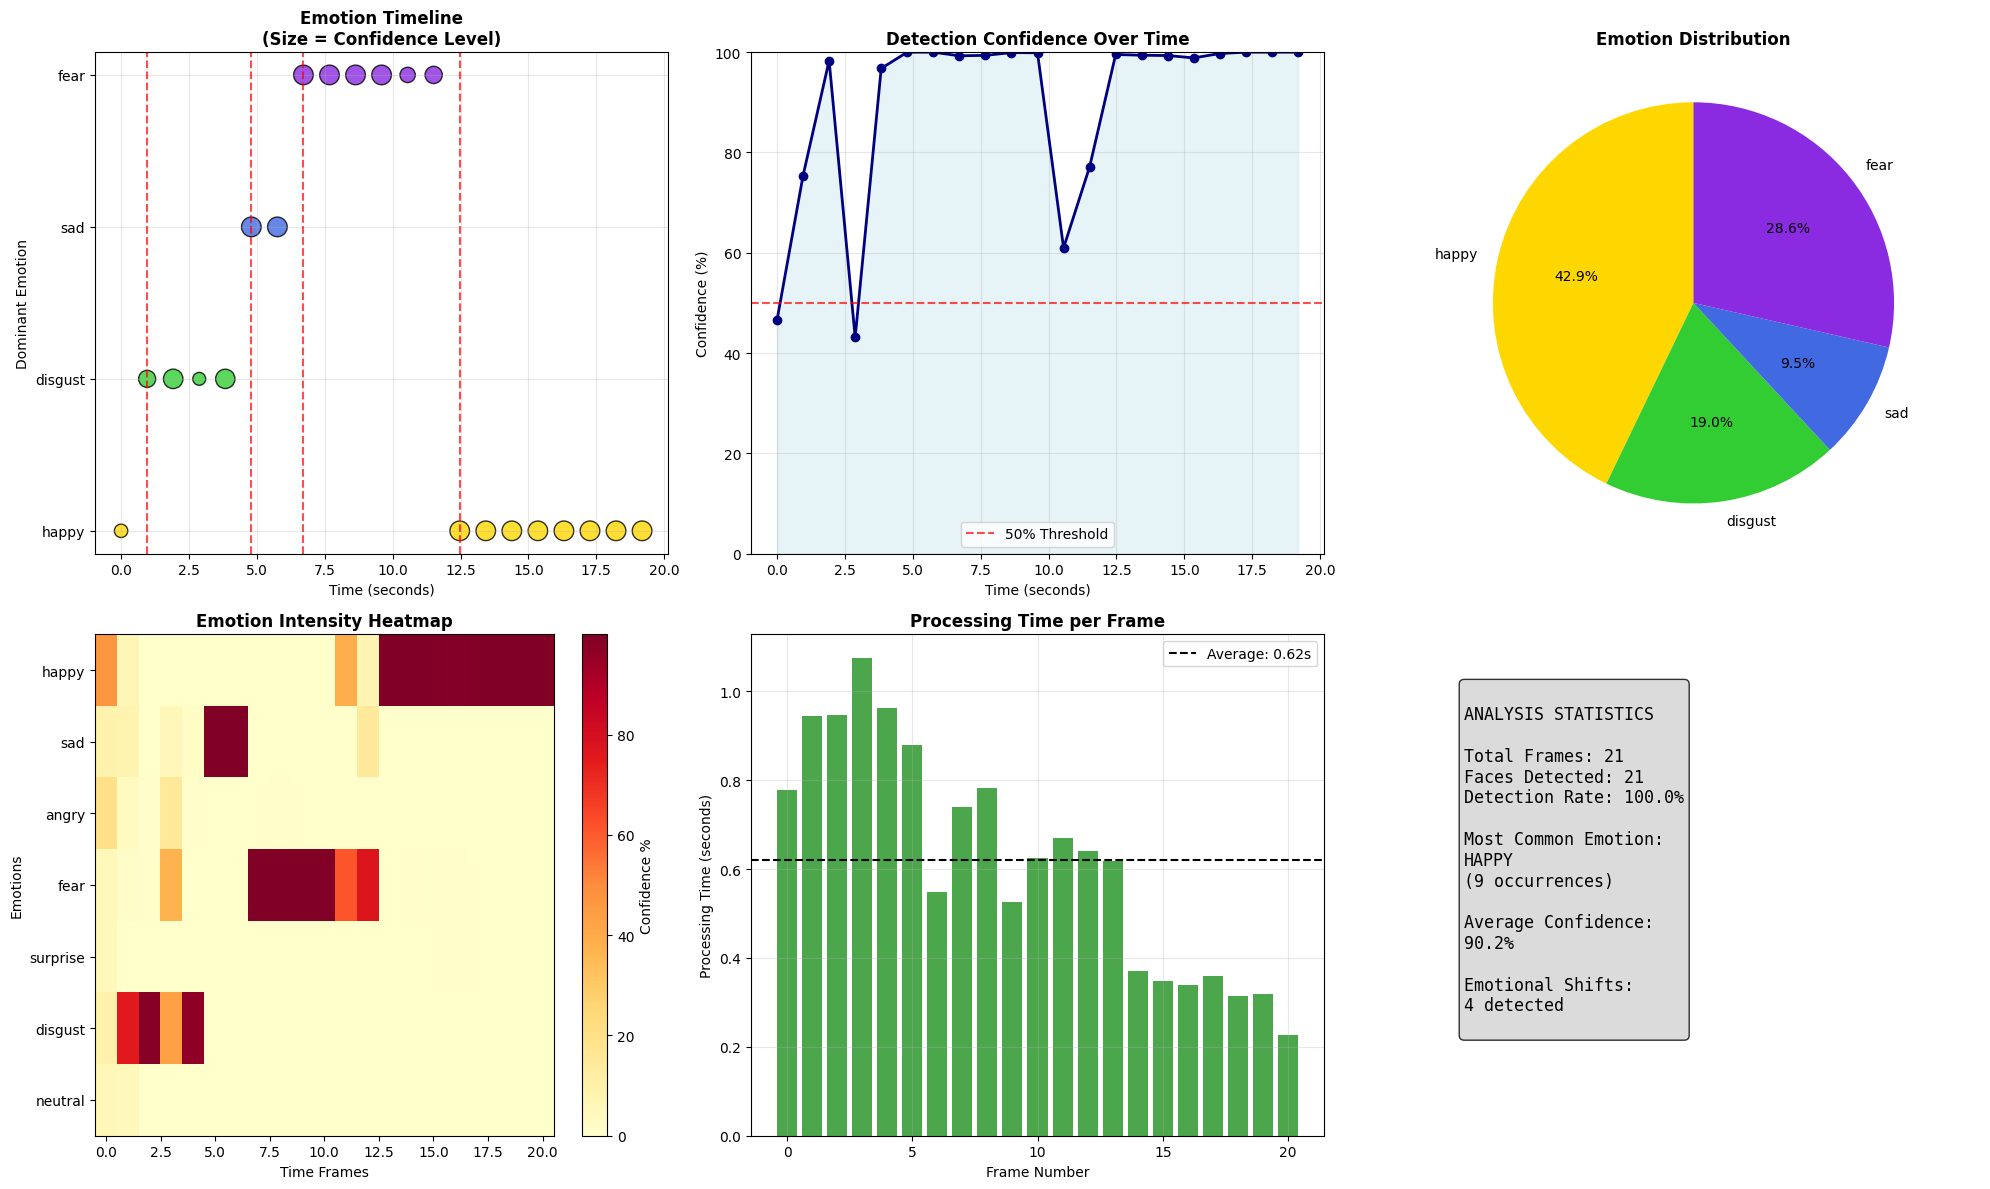

In [241]:
# display visualizations
create_emotion_visualizations(emotion_results, summary)

***Step-11: Display Detailed Results and Save Output***

---



In [242]:
def display_detailed_results(emotion_results, summary):
    """Display comprehensive results in a formatted way"""
    print("=" * 80)
    print("FACIAL EMOTION ANALYSIS - DETAILED RESULTS")
    print("=" * 80)

    # Frame-by-frame results
    print("\n FRAME-BY-FRAME ANALYSIS:")
    print("-" * 50)
    print(f"{'Time':<8} {'Emotion':<12} {'Confidence':<12} {'Status'}")
    print("-" * 50)

    for result in emotion_results:
        timestamp = result['timestamp']
        emotion = result['dominant_emotion']
        confidence = result['confidence']
        status = " Detected" if result['face_detected'] else " No Face"

        print(f"{timestamp:6.1f}s  {emotion:<12} {confidence:8.1f}%    {status}")

    # Summary statistics
    print(f"\n SUMMARY STATISTICS:")
    print("-" * 50)
    print(f"Total frames processed: {summary['total_frames']}")
    print(f"Successful detections: {summary['faces_detected']}")
    print(f"Detection success rate: {summary['detection_rate']:.1f}%")
    print(f"Most frequent emotion: {summary['most_common_emotion'].upper()}")
    print(f"Average confidence: {summary['average_confidence']:.1f}%")

    # Emotion breakdown
    print(f"\n EMOTION DISTRIBUTION:")
    print("-" * 30)
    for emotion, count in summary['emotion_distribution'].items():
        percentage = (count / summary['faces_detected']) * 100 if summary['faces_detected'] > 0 else 0
        print(f"{emotion.capitalize():<12}: {count:2d} times ({percentage:5.1f}%)")

    # Emotional transitions
    if summary['emotional_shifts']:
        print(f"\n EMOTIONAL TRANSITIONS:")
        print("-" * 40)
        for i, shift in enumerate(summary['emotional_shifts'], 1):
            print(f"{i:2d}. {shift}")
    else:
        print(f"\n No significant emotional transitions detected.")

    print("\n" + "=" * 80)

# Display detailed results
display_detailed_results(emotion_results, summary)

FACIAL EMOTION ANALYSIS - DETAILED RESULTS

 FRAME-BY-FRAME ANALYSIS:
--------------------------------------------------
Time     Emotion      Confidence   Status
--------------------------------------------------
   0.0s  happy            46.6%     Detected
   1.0s  disgust          75.4%     Detected
   1.9s  disgust          98.3%     Detected
   2.9s  disgust          43.1%     Detected
   3.8s  disgust          96.8%     Detected
   4.8s  sad             100.0%     Detected
   5.8s  sad             100.0%     Detected
   6.7s  fear             99.3%     Detected
   7.7s  fear             99.4%     Detected
   8.6s  fear             99.9%     Detected
   9.6s  fear             99.9%     Detected
  10.6s  fear             61.0%     Detected
  11.5s  fear             77.1%     Detected
  12.5s  happy            99.5%     Detected
  13.4s  happy            99.4%     Detected
  14.4s  happy            99.3%     Detected
  15.3s  happy            98.9%     Detected
  16.3s  happy       

***Step-12: Save Results to Different Files***

---



In [243]:
def save_results(emotion_results, summary, frames, timestamps):
    """Save analysis results to files"""
    print("Saving results to files...")

    # 1. Save detailed results as JSON
    results_data = {
        'metadata': {
            'total_frames': len(frames),
            'analysis_timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'video_duration': max(timestamps) if timestamps else 0
        },
        'summary': summary,
        'frame_results': emotion_results
    }

    with open('emotion_analysis_results.json', 'w') as f:
        json.dump(results_data, f, indent=2, default=str)

    # 2. Save results as CSV
    df_data = []
    for result in emotion_results:
        row = {
            'timestamp': result['timestamp'],
            'dominant_emotion': result['dominant_emotion'],
            'confidence': result['confidence'],
            'face_detected': result['face_detected'],
            'processing_time': result['processing_time']
        }
        # Add individual emotion scores
        if result['all_emotions']:
            for emotion, score in result['all_emotions'].items():
                row[f'emotion_{emotion}'] = score
        df_data.append(row)

    df = pd.DataFrame(df_data)
    df.to_csv('emotion_analysis_results.csv', index=False)

    # 3. Save summary report as text
    with open('emotion_analysis_summary.txt', 'w') as f:
        f.write("EMOTION ANALYSIS SUMMARY REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(summary['summary_text'])
        f.write("\n\nDETAILED FRAME ANALYSIS:\n")
        f.write("-" * 30 + "\n")
        for result in emotion_results:
            f.write(f"{result['timestamp']:6.1f}s: {result['dominant_emotion']:<12} "
                   f"({result['confidence']:5.1f}%)\n")

    print("Results saved successfully!")
    print("   emotion_analysis_results.json")
    print("   emotion_analysis_results.csv")
    print("   emotion_analysis_summary.txt")

    return df


In [244]:
# Save all results
results_df = save_results(emotion_results, summary, frames, timestamps)

Saving results to files...
Results saved successfully!
   emotion_analysis_results.json
   emotion_analysis_results.csv
   emotion_analysis_summary.txt


In [245]:
# Display final summary
print("\n ANALYSIS COMPLETE!")
print("=" * 50)
print(summary['summary_text'])


 ANALYSIS COMPLETE!

EMOTION ANALYSIS SUMMARY:
• Most common emotion: HAPPY (9 times)
• Face detection rate: 100.0% (21/21 frames)
• Average confidence: 90.2%
• Total emotional shifts: 4

Key emotional transitions:
  • happy → disgust at 1.0s
  • disgust → sad at 4.8s
  • sad → fear at 6.7s



# Displaying some Sample Frames with Detected Emotions


 Displaying sample frames with detected facial emotions...


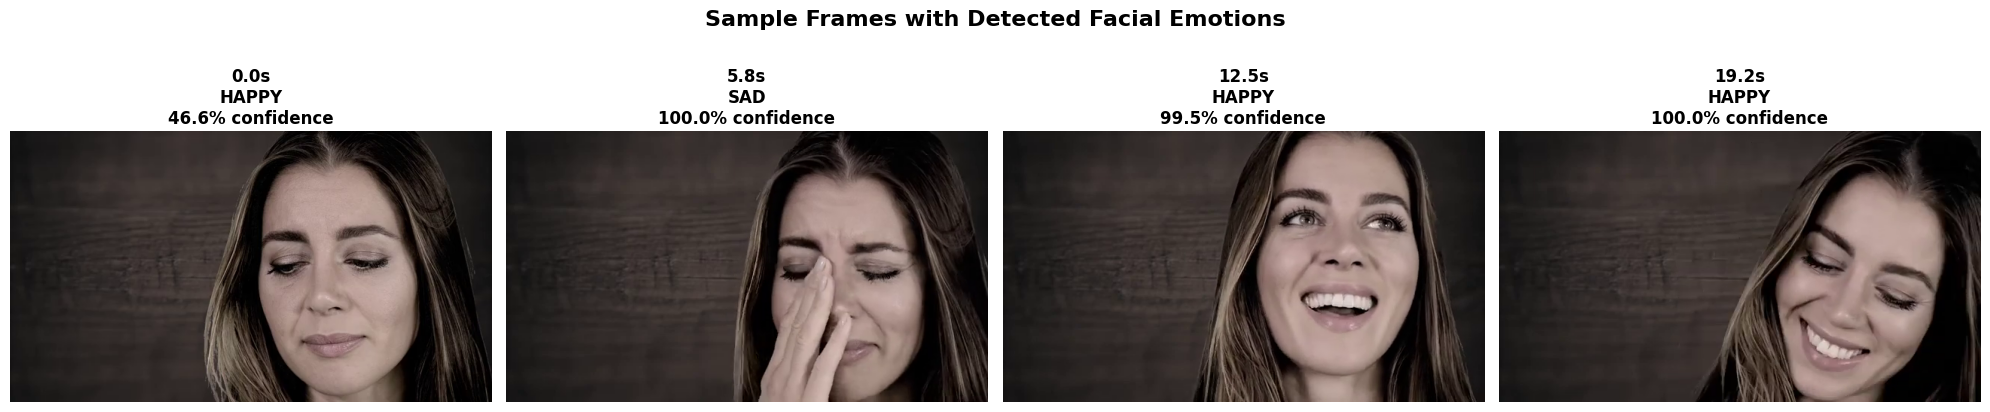

In [246]:
def display_sample_frames_with_emotions(frames, emotion_results, max_samples=4):
    """Display sample frames with their detected facial emotions"""
    valid_indices = [i for i, r in enumerate(emotion_results) if r['face_detected']]

    if not valid_indices:
        print(" No frames with detected faces to display")
        return

    print(f" Displaying sample frames with detected facial emotions...")

    #randomly selection
    sample_count = min(max_samples, len(valid_indices))
    if sample_count > 1:
        sample_indices = np.linspace(0, len(valid_indices)-1, sample_count, dtype=int)
        selected_indices = [valid_indices[i] for i in sample_indices]
    else:
        selected_indices = [valid_indices[0]]

    fig, axes = plt.subplots(1, sample_count, figsize=(5*sample_count, 5))
    if sample_count == 1:
        axes = [axes]

    for i, idx in enumerate(selected_indices):
        frame = frames[idx]
        result = emotion_results[idx]

        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        axes[i].imshow(frame_rgb)
        title = f'{result["timestamp"]:.1f}s\n{result["dominant_emotion"].upper()}\n{result["confidence"]:.1f}% confidence'
        axes[i].set_title(title, fontweight='bold', fontsize=12)
        axes[i].axis('off')

    plt.suptitle('Sample Frames with Detected Facial Emotions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Display sample frames
display_sample_frames_with_emotions(frames, emotion_results)